In [ ]:
import json
import os
import sys

import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import skewnorm
from sklearn.preprocessing import PowerTransformer

# Import modules defined in src/
sys.path.append(os.path.abspath("../src"))
from seasonality import SeasonalPlotter

In [ ]:
# Set seaborn theme
sns.set_theme()

# Get data

Read your personal API key

In [ ]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [ ]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"

data = pd.DataFrame()

for site_id in ["FR15038", "FR15043", "FR15053"]:
    params = {
        "api_token": API_KEY,
        "format": "json",
        "sites": site_id,
        "date_debut": "-2 years",
        "label_court_polluant": "PM2.5",
        "order_by_date": "asc",
        "valeur_brute": "1",
    }

    # Make the GET request
    response = requests.get(url, params=params)

    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

    while response["links"]["next"] is not None:
        response = requests.get(response["links"]["next"])
        response = json.loads(response.text)
        data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.tz_localize(None)

In [ ]:
class site:
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]

        if self.data.empty:
            raise ValueError("No data available for this site")

        self.site_id = site_id

        self.reference_data = self.data.query("type_appareil_id == 11")
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data.query("type_appareil_id == 57")
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data

    def get_microsensor_data(self):
        return self.microsensor_data

    def get_reference_values(self):
        return self.reference_values

    def get_microsensor_values(self):
        return self.microsensor_values

    def filter_date(self, start_date, end_date):
        reference = self.get_reference_data()
        microsensor = self.get_microsensor_data()

        reference = reference[
            (reference["date"] >= start_date) & (reference["date"] <= end_date)
        ]
        microsensor = microsensor[
            (microsensor["date"] >= start_date) & (microsensor["date"] <= end_date)
        ]

        return reference, microsensor

    def plot(self, ax=None, *, kwargs={}):
        if ax is None:
            ax = plt.gca()

        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        ax.plot(x_ref, y_ref, label="Reference values")
        ax.plot(x_micro, y_micro, label="Microsensor values")
        ax.set_title(f"PM2.5 values for site {self.site_id}")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 values (µg/m³)")
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
        )
        ax.legend()

        return ax

In [ ]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15053",
}

LF = site(data, site_id_dict["Les Frenes"])
SMH = site(data, site_id_dict["Saint Martin d'Hères"])

# Descriptive statistics
On the SMH station

## Differences

In [ ]:
# Filter on date
smh_reference, smh_microsensor = SMH.filter_date("2023-01-01", "2023-12-31")
lf_reference, lf_microsensor = LF.filter_date("2023-01-01", "2023-12-31")

# Split dataframe by microsensor id for les fresnes
lf_microsensor_dict = {}
for microsensor_id in [
    "FR15043_39_57_3_C1",
    "FR15043_39_57_4_C1",
    "FR15043_39_57_5_C1",
]:
    lf_microsensor_dict[microsensor_id] = lf_microsensor[
        lf_microsensor["mesure_id"] == microsensor_id
    ]

# Merge microsensor and reference data
smh_data = pd.merge(smh_reference, smh_microsensor, on="date")
lf_data = {}
for microsensor_id in [
    "FR15043_39_57_3_C1",
    "FR15043_39_57_4_C1",
    "FR15043_39_57_5_C1",
]:
    lf_data[microsensor_id] = pd.merge(
        lf_reference, lf_microsensor_dict[microsensor_id], on="date"
    )

In [ ]:
# Compute difference
smh_data["diff"] = smh_data["valeur_y"] - smh_data["valeur_x"]
for microsensor_id in [
    "FR15043_39_57_3_C1",
    "FR15043_39_57_4_C1",
    "FR15043_39_57_5_C1",
]:
    lf_data[microsensor_id]["diff"] = (
        lf_data[microsensor_id]["valeur_y"] - lf_data[microsensor_id]["valeur_x"]
    )

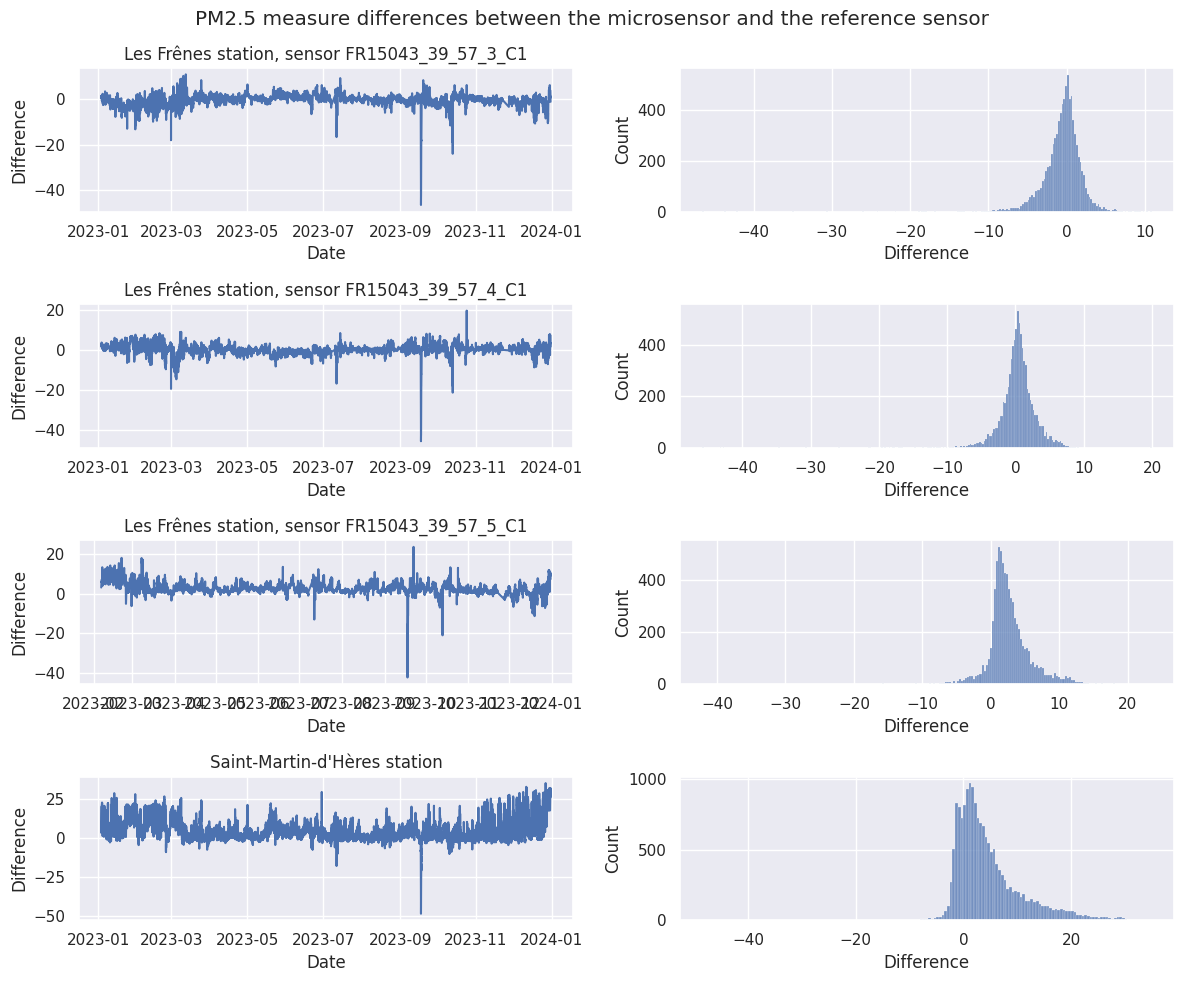

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))

for ax_idx, microsensor_id in enumerate(
    ["FR15043_39_57_3_C1", "FR15043_39_57_4_C1", "FR15043_39_57_5_C1"]
):
    axes[ax_idx, 0].plot(
        lf_data[microsensor_id]["date"], lf_data[microsensor_id]["diff"]
    )
    axes[ax_idx, 0].set_xlabel("Date")
    axes[ax_idx, 0].set_ylabel("Difference")
    axes[ax_idx, 0].set_title(f"Les Frênes station, sensor {microsensor_id}")

    sns.histplot(lf_data[microsensor_id]["diff"], ax=axes[ax_idx, 1])
    axes[ax_idx, 1].set_xlabel("Difference")

axes[3, 0].plot(smh_data["date"], smh_data["diff"])
axes[3, 0].set_xlabel("Date")
axes[3, 0].set_ylabel("Difference")

sns.histplot(smh_data["diff"], ax=axes[3, 1])
axes[3, 1].set_xlabel("Difference")
axes[3, 0].set_title("Saint-Martin-d'Hères station")

plt.suptitle(
    "PM2.5 measure differences between the microsensor and the reference sensor"
)
plt.tight_layout()
plt.show()

The microsensor of the Saint-Martin-d'Hères station overmeasures systematically the rate of PM2.5 relatively to its reference sensor.  
The Les Frênes microsensor is unbiased but with the same order of magnitude of deviation.

## Distribution

A regular distribution $\mathcal{D}$ of the difference between the reference measure and the microsensor one seems to be best represented by the FR15043_39_57_3_C1 and the FR15043_39_57_4_C1 sensors.  

These distributions are the most narrowed, ranging between -10 and 10, and are not skewed. Hence, measures living into the symmetric interval centered in zero and containing 95% of the data of the distribution $\mathcal{D}$ can be considered valid.  

Specific flaws in the microsensors such as over-measurement, represented by skewness in the difference distribution, will be dealt with more attention in a next step.  

**Let us study the distribution $\mathcal{D}$:**

In [ ]:
dist_to_study = lf_data["FR15043_39_57_3_C1"]["diff"]

Transform the data

For getting a better fit to a gaussian distribution, we can utilize the Yeo-Johnson transformation.  
https://feaz-book.com/numeric-yeojohnson

In [ ]:
# Perform transformation and scaling (0 mean, unit variance)
transformer = PowerTransformer(method="yeo-johnson", standardize=True)
dist_to_study = np.array(dist_to_study).reshape(-1, 1)
transformed = transformer.fit_transform(dist_to_study)

print(
    f"Optimal lamdba parameter of Yeo-Johnson transformation: {round(transformer.lambdas_[0], 2)}"
)

Optimal lamdba parameter of Yeo-Johnson transformation: 1.24


In [ ]:
# Sample x values
xx = np.linspace(-15, 15, 100)

# Set parameters of estimated normal density function
skewness, mean, std = 0, 0, 1

# Compute normal density function
yy = skewnorm.pdf(xx, skewness, mean, std)

Text(0.5, 1.0, "PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station\nScaled and transformed data")

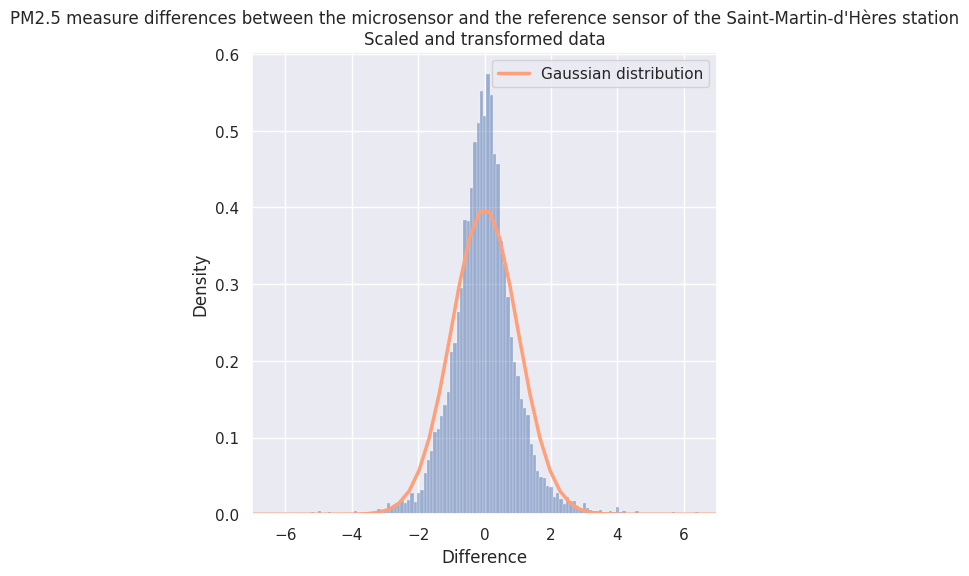

In [ ]:
# Plot the estimated distribution vs the histogram
plt.figure(figsize=(6, 6))
sns.histplot(transformed, stat="density")
plt.plot(xx, yy, label="Gaussian distribution", color="#FFA07A", linewidth=2.5)
plt.legend()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.xlim((-7, 7))
plt.title(
    "PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station\nScaled and transformed data"
)

In [ ]:
# Compute the interval containing 95% of the original data
inter_start, inter_stop = transformer.inverse_transform(
    np.array([[-1.96]])
), transformer.inverse_transform(np.array([[1.96]]))
valid_interval = [inter_start[0, 0], inter_stop[0, 0]]
print(
    f"95% of measures lay between {round(valid_interval[0], 2)} and {round(valid_interval[1], 2)}."
)

95% of measures lay between -6.09 and 3.22.


/tmp/ipykernel_9489/2154573016.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, "PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station\nOriginal data")

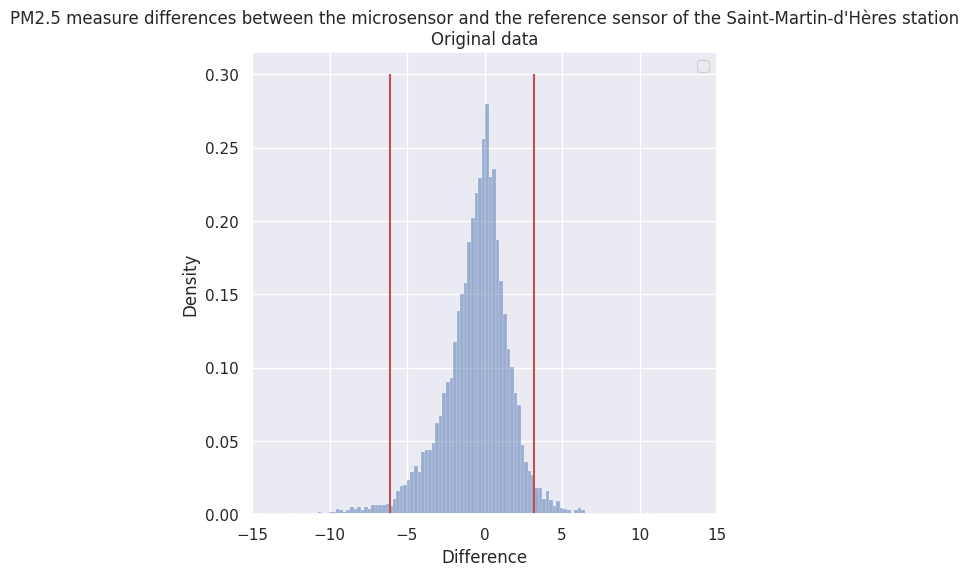

In [ ]:
# Plot the difference distribution
plt.figure(figsize=(6, 6))
sns.histplot(dist_to_study, stat="density")
plt.legend()
plt.xlabel("Difference")
plt.ylabel("Density")
plt.xlim((-15, 15))
plt.vlines(inter_start, 0, 0.3, color="r")
plt.vlines(inter_stop, 0, 0.3, color="r")
plt.title(
    "PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station\nOriginal data"
)

## Rolling statistics

In [ ]:
# Take one microsensor only for les fresnes from now
lf_data = lf_data["FR15043_39_57_3_C1"]

In [ ]:
for dataset in [smh_data, lf_data]:
    for column in ["x", "y"]:
        dataset[f"moving_average_48_{column}"] = (
            dataset[f"valeur_{column}"].rolling(48).mean()
        )
        dataset[f"moving_variance_48_{column}"] = (
            dataset[f"valeur_{column}"].rolling(48).var()
        )

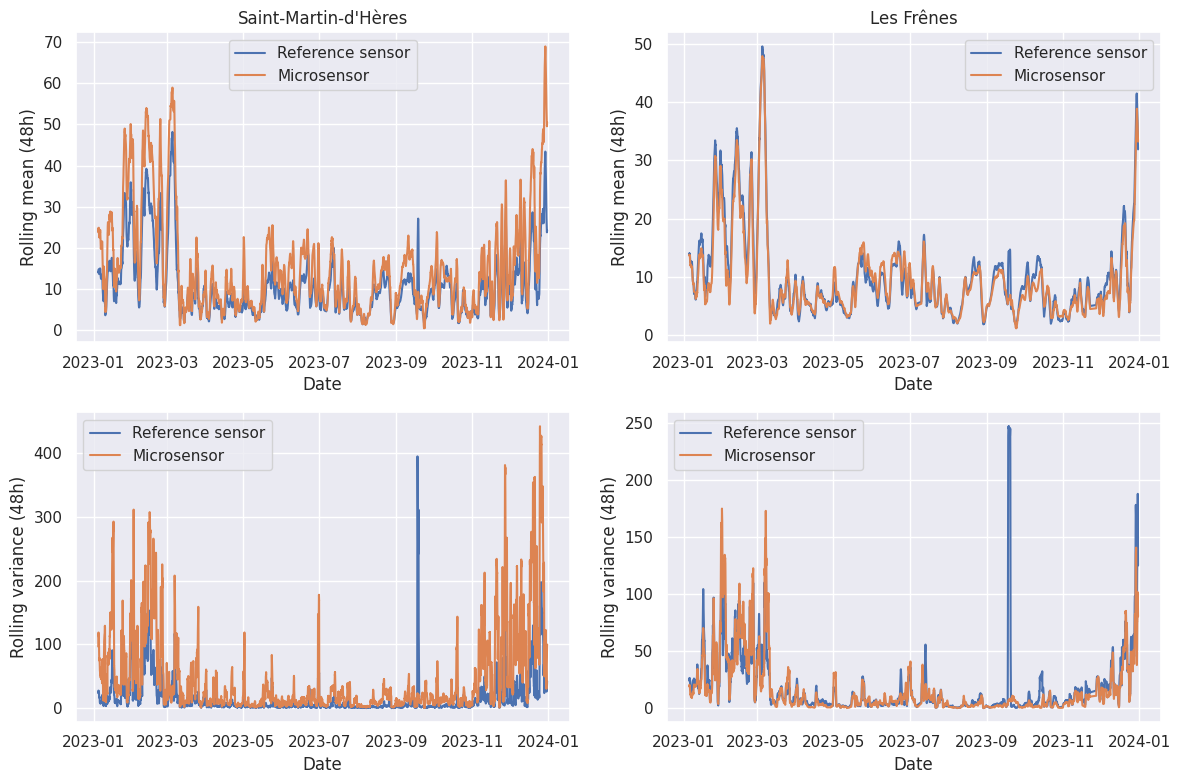

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot moving average for smh_data
axs[0, 0].plot(
    smh_data["date"], smh_data["moving_average_48_x"], label="Reference sensor"
)
axs[0, 0].plot(smh_data["date"], smh_data["moving_average_48_y"], label="Microsensor")
axs[0, 0].set_ylabel("Rolling mean (48h)")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_title("Saint-Martin-d'Hères")
axs[0, 0].legend()

# Plot moving variance for smh_data
axs[1, 0].plot(
    smh_data["date"], smh_data["moving_variance_48_x"], label="Reference sensor"
)
axs[1, 0].plot(smh_data["date"], smh_data["moving_variance_48_y"], label="Microsensor")
axs[1, 0].set_ylabel("Rolling variance (48h)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].legend()

# Plot moving average for lf_data
axs[0, 1].plot(
    lf_data["date"], lf_data["moving_average_48_x"], label="Reference sensor"
)
axs[0, 1].plot(lf_data["date"], lf_data["moving_average_48_y"], label="Microsensor")
axs[0, 1].set_ylabel("Rolling mean (48h)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_title("Les Frênes")
axs[0, 1].legend()

# Plot moving variance for lf_data
axs[1, 1].plot(
    lf_data["date"], lf_data["moving_variance_48_x"], label="Reference sensor"
)
axs[1, 1].plot(lf_data["date"], lf_data["moving_variance_48_y"], label="Microsensor")
axs[1, 1].set_ylabel("Rolling variance (48h)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Seasonal plot

In [ ]:
# Copy dataframe for seasonal plot
smh_data_seasonality = smh_data.copy()

In [ ]:
# Set datetime column as index
smh_data_seasonality.set_index("date", inplace=True, drop=True)

In [ ]:
# Adapt pandas index type for passing df to the seasonal plot function
smh_data_seasonality.index = smh_data_seasonality.index.to_period("h")

In [ ]:
# Define time variables
smh_data_seasonality["dayofyear"] = smh_data_seasonality.index.dayofyear
smh_data_seasonality["hourofday"] = smh_data_seasonality.index.hour
smh_data_seasonality["monthofyear"] = smh_data_seasonality.index.month

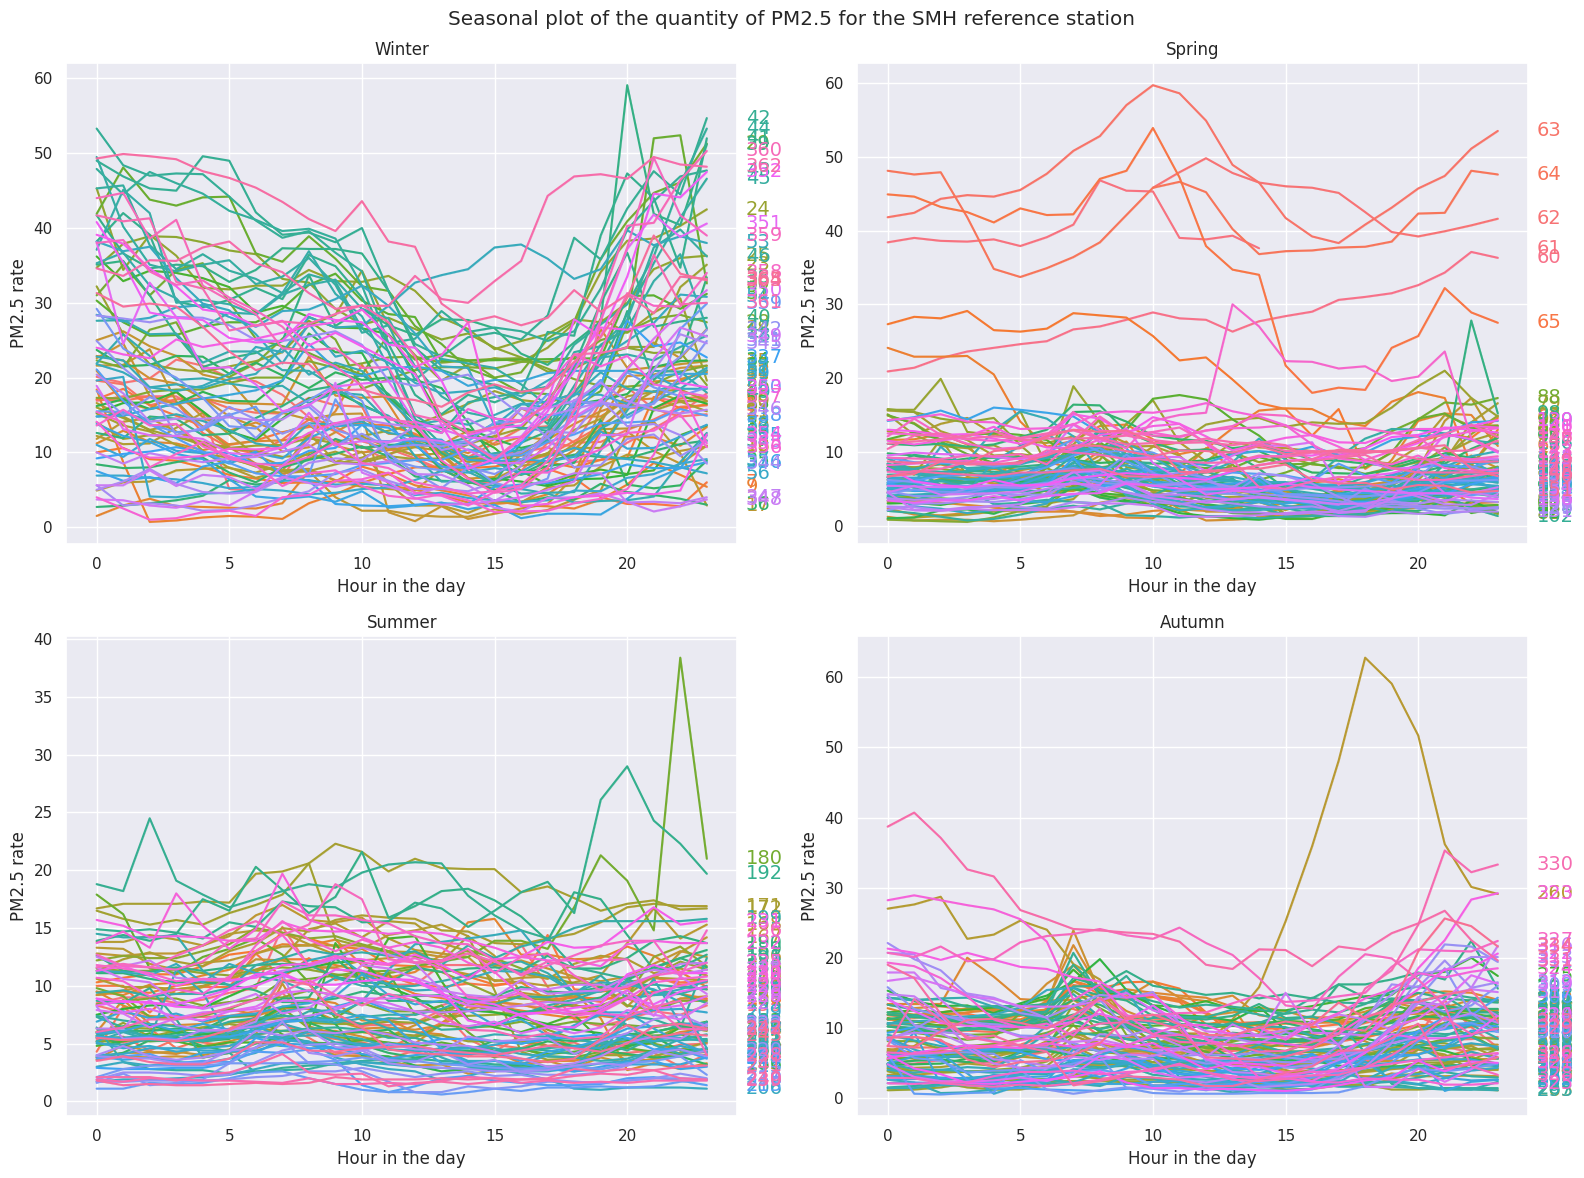

In [ ]:
# Define seasons based on months
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Iterate through seasons and create plots
for i, (season, months) in enumerate(seasons.items()):
    # Filter data for the current season
    season_data = smh_data_seasonality[smh_data_seasonality["monthofyear"].isin(months)]

    SeasonalPlotter.seasonal_plot(
        X=season_data, y="valeur_x", period="dayofyear", freq="hourofday", ax=axes[i]
    )

    axes[i].set_ylabel("PM2.5 rate")
    axes[i].set_xlabel("Hour in the day")
    axes[i].set_title(season)

plt.suptitle("Seasonal plot of the quantity of PM2.5 for the SMH reference station")
plt.tight_layout()
plt.show()